## IMPORTING NECESSARY MODULES

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

Using TensorFlow backend.


**The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from Szegedy et al.. I have provided an inception network implementation. You can look in the file inception_blocks.py to see how it is implemented**.

**This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of  mm  face images) as a tensor of shape  (m,nC,nH,nW)=(m,3,96,96)(m,nC,nH,nW)=(m,3,96,96)**

### BUILDING THE MODEL

In [2]:
#We have a function in utils.py that will load our model given the input shape
frmodel=faceRecoModel(input_shape=(3,96,96))

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#Counting total number of parameters to train
print("Total number of parametrs to train is equal to {}".format(frmodel.count_params()))

Total number of parametrs to train is equal to 3743280


### LOADING WEIGHT OF THE TRAINED MODEL

**FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run.**

In [4]:
load_weights_from_FaceNet(frmodel)
print('WEIGHTS LOADED SUCCESSFULLY')

WEIGHTS LOADED SUCCESSFULLY


###  FUNCTION RETURNING THE EMBEDDINGS

In [5]:

def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    #By default cv2 read image as BGR
    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #Getting the channel first
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

## TRAINING DATA

In [6]:
img_abd=cv2.imread('images/abd2.jpg',1)
img_shu=cv2.imread('images/shubham.jpg',1)

In [7]:
database={}
database['AB de Villiers']=image_to_embedding(img_abd,frmodel)
database['Shubham']=image_to_embedding(img_shu,frmodel)

#### LET"S TAKE A LOOK AT TRAINING SET

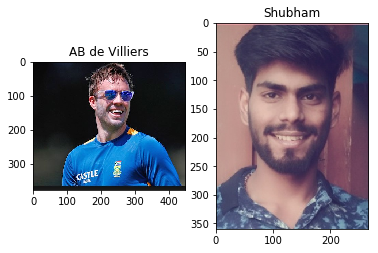

In [8]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.title('AB de Villiers')
plt.imshow(cv2.cvtColor(img_abd,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('Shubham')
plt.imshow(cv2.cvtColor(img_shu,cv2.COLOR_BGR2RGB))
plt.show()

### FUNCTION FOR FACE RECOGNITION

In [10]:
def who_is_it (image) :
    result=''
    encod = image_to_embedding(image,frmodel)
    min_dist = 100 
    for (name,db_enc) in database.items() :
        dist = np.linalg.norm(encod-db_enc)
        if dist < min_dist :
            min_dist = dist 
            identity = name
    if min_dist > 0.8:
        result="Not in database"
    else:
        result = "Welcome " + str (identity)
    return result

### TEST TIME

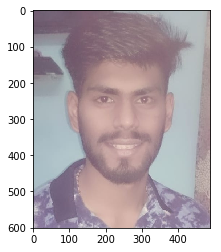

Welcome Shubham


In [11]:
#FIRST IMAGE
img_test=cv2.imread('test/shubhamtest.jpg',1)
plt.imshow(cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB))
plt.show()
print(who_is_it(img_test))

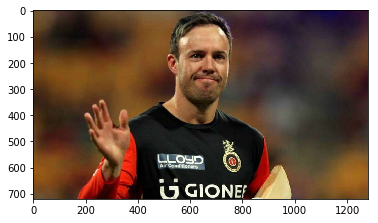

Welcome AB de Villiers


In [12]:
#SECOND IMAGE
img_test1=cv2.imread('test/abdtest.jpg',1)
plt.imshow(cv2.cvtColor(img_test1,cv2.COLOR_BGR2RGB))
plt.show()
print(who_is_it(img_test1))

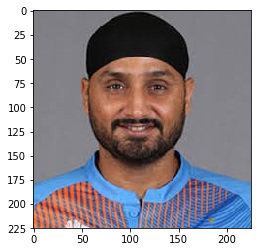

Not in database


In [13]:
#THIRD IMAGE
img_test2=cv2.imread('test/download.jpg',1)
plt.imshow(cv2.cvtColor(img_test2,cv2.COLOR_BGR2RGB))
plt.show()
print(who_is_it(img_test2))

**For face detection devices used in industry we use both face recognition and liveness detection together**

## CV2 function for drawing rectangle and face recognition

In [14]:
def draw(image) :
    face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    frame_dim=face_cascade.detectMultiScale(image)
    offset=15
    for (x,y,w,h) in frame_dim :
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,255),6)
        face_section=image[y-offset:y+h+offset,x-offset:x+w+offset]
        text=who_is_it(face_section)
        cv2.putText(image,text,(x,y-10),(cv2.FONT_HERSHEY_SIMPLEX),1,(255,0,0),2,cv2.LINE_AA)
        

# REAL-TIME FACE RECOGNITION

In [15]:
import cv2
cap=cv2.VideoCapture(0)
while True :
    ret,frame = cap.read()
    draw(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q') :
        break
cap.release()
cv2.destroyAllWindows()